In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

In [2]:
from IPython.display import display, HTML

In [3]:
display(HTML(data = """
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

### Input and results folders

In [2]:
data_powergenome = os.path.join(os.path.abspath('..'), 'data/powergenome')
data_extra = os.path.join(os.path.abspath('..'), 'data/extra/extra_inputs')

result_eeo_reference = os.path.join(os.path.abspath('..'), 'results/eeo/reference')
result_eeo_heterogeneity = os.path.join(os.path.abspath('..'), 'results/eeo/heterogeneity')

result_abm = os.path.join(os.path.abspath('..'), 'results/abm')
result_iam = os.path.join(os.path.abspath('..'), 'results/iam')

### Figure parameters

In [3]:
fig1 = 15
fig2 = 9
fs = 10
dpi_qual = 300

### Reading results for EEO

In [4]:
def sort_with_generators(path, namedf, iscap, isdispatch, isstart, isstor, stordata):
    
    if isstor == False:
        data = pd.read_csv(os.path.join(path, namedf))
    else:
        data = stordata
    
    if isdispatch == True or isstart == True or isstor == True:
        data = data.rename(columns = {'Index':'R_ID'})
        
    data = data.set_index('R_ID')
    data = data.reindex(index = generators['R_ID'])
    data = data.reset_index()
    
    if iscap == True:
        data = data.drop(columns = ['R_ID', 'Zone', 'Region', 'Resource', 'NOS'])
    else:
        data = data.drop(columns = ['R_ID', 'Zone', 'Region', 'Resource'])
    
    if isstart == True or isstor == True:
        data = data.fillna(0)
        
    return data

In [5]:
def prepare_dataframe(path, namedf):
    data = pd.read_csv(os.path.join(path, namedf))
    data = data.transpose()
    data.columns = data.iloc[0] 
    data = data[1:]
    data = data / 1000
    return data

In [6]:
generators = pd.read_csv(os.path.join(data_powergenome, "Generators_data.csv"))

load = pd.read_csv(os.path.join(data_powergenome, "Load_data.csv"))

cost_nonserved = load.Cost_of_demand_curtailment_perMW.dropna()[0] * load.Voll[0]
cost_voluntary = load.Cost_of_demand_curtailment_perMW.dropna()[1] * load.Voll[0]

sample_weight = np.repeat(load.Sub_Weights.dropna().tolist() / load.Timesteps_per_Rep_Period.dropna()[0], load.Timesteps_per_Rep_Period.dropna()[0])

network = pd.read_csv(os.path.join(data_powergenome, "Network.csv"))

pronetwork = pd.read_csv(os.path.join(data_extra, "new_transmission_lines.csv"))

hurdle = pd.read_csv(os.path.join(data_extra, "hurdle_rates.csv"))

rein_to_fixed = pd.read_csv(os.path.join(data_extra, "other_inputs.csv"))[pd.read_csv(os.path.join(data_extra, "other_inputs.csv"))['Parameter'] == 'reinforcement_to_fixed']['Value'].tolist()[0]

costs = [pd.read_csv(os.path.join(result_eeo_reference, "cost_components.csv")),
         pd.read_csv(os.path.join(result_eeo_heterogeneity, "cost_components.csv"))]

allcap = [sort_with_generators(result_eeo_reference, "allcap.csv", 
                    iscap = True, isdispatch = False, isstart = False, isstor = False, stordata = None),
          sort_with_generators(result_eeo_heterogeneity, "allcap.csv", 
                    iscap = True, isdispatch = False, isstart = False, isstor = False, stordata = None)]

aggregated_cap = [prepare_dataframe(result_eeo_reference, "allcap_aggregate.csv"),
                  prepare_dataframe(result_eeo_heterogeneity, "allcap_aggregate.csv")]

# Normally, taking vRETESTOROLD_results is wrong because these show retired capacity, not the final capacity. But, investment and fixed cost are zero for these resources. Hence, results are not affected by this fallacy.
stor_merged_without = pd.concat([pd.read_csv(os.path.join(result_eeo_reference, "vCAPESTORNEW_results.csv")), 
                                 pd.read_csv(os.path.join(result_eeo_reference, "vCAPESTORSTABLE_results.csv")), 
                                 pd.read_csv(os.path.join(result_eeo_reference, "vRETESTOROLD_results.csv"))])
stor_merged_with = pd.concat([pd.read_csv(os.path.join(result_eeo_heterogeneity, "vCAPESTORNEW_results.csv")), 
                              pd.read_csv(os.path.join(result_eeo_heterogeneity, "vCAPESTORSTABLE_results.csv")), 
                              pd.read_csv(os.path.join(result_eeo_heterogeneity, "vRETESTOROLD_results.csv"))])

stor_merged = [sort_with_generators(None, None, iscap = False, isdispatch = False, isstart = False, 
                                    isstor = True, stordata = stor_merged_without),
               sort_with_generators(None, None, iscap = False, isdispatch = False, isstart = False, 
                                    isstor = True, stordata = stor_merged_with)]

dispatch = [sort_with_generators(result_eeo_reference, "vGENDISPATCH_results.csv", 
                    iscap = False, isdispatch = True, isstart = False, isstor = False, stordata = None),
            sort_with_generators(result_eeo_heterogeneity, "vGENDISPATCH_results.csv", 
                    iscap = False, isdispatch = True, isstart = False, isstor = False, stordata = None)]

nse_withoutins, nse_withins = [], []
for x in generators.Zone.unique():
    nse_withoutins.append(pd.read_csv(os.path.join(result_eeo_reference, "vNSE" + str(x) + ".csv")))
    nse_withins.append(pd.read_csv(os.path.join(result_eeo_heterogeneity, "vNSE" + str(x) + ".csv")))
nse = [nse_withoutins, nse_withins]   

start = [sort_with_generators(result_eeo_reference, "vSTARTUC_results.csv", 
                    iscap = False, isdispatch = False, isstart = True, isstor = False, stordata = None),
         sort_with_generators(result_eeo_heterogeneity, "vSTARTUC_results.csv", 
                    iscap = False, isdispatch = False, isstart = True, isstor = False, stordata = None)]

capline = [pd.read_csv(os.path.join(result_eeo_reference, "vCAPLINE_results.csv")),
           pd.read_csv(os.path.join(result_eeo_heterogeneity, "vCAPLINE_results.csv"))]

flow = pd.read_csv(os.path.join(result_eeo_heterogeneity, "vFLOW_results.csv"))

scenario_name_iam = ['Reference', 'Policy Heterogeneity']
scenario_name_eeo = ['Reference', 'Coordination Heterogeneity']
scenario_name_abm = ['Reference', 'Norm Heterogeneity']

### Reading results for IAM

In [7]:
results_iam = pd.read_excel(result_iam + '/gcam-usa_data.xlsx')
iam_cost_withoutins, iam_cost_withins = results_iam.iloc[3]['Unnamed: 2'], results_iam.iloc[3]['Unnamed: 1']

In [8]:
iam_dist_costs = results_iam.iloc[6:10]
iam_dist_costs.columns = iam_dist_costs.iloc[0]
iam_dist_costs = iam_dist_costs.drop(6)
indextobe = iam_dist_costs.iloc[:, 0].tolist()
iam_dist_costs = iam_dist_costs.iloc[: , 1:]
iam_dist_costs['States'] = indextobe
iam_dist_costs = iam_dist_costs.set_index('States')
iam_dist_costs = iam_dist_costs * 100

### Reading results for ABM

In [9]:
results_abm = pd.read_excel(result_abm + "/energy_model_results.ods", engine = 'odf') # install odfpy package with 'pip insall odfpy beforehand'
abm_pv_withoutins, abm_pv_withins = results_abm.iloc[1]['Without institutions(Rational agents)'], results_abm.iloc[1]['With institutions(Behavioral agents)']

In [10]:
abm_dist_costs = results_abm.iloc[13:21]
abm_dist_costs.columns = abm_dist_costs.iloc[0]
abm_dist_costs = abm_dist_costs.drop(13)
indextobe = abm_dist_costs.iloc[:, 0].tolist()
abm_dist_costs = abm_dist_costs.iloc[: , 1:]
abm_dist_costs['Groups'] = indextobe
abm_dist_costs = abm_dist_costs.set_index('Groups')
abm_dist_costs = abm_dist_costs * 100
abm_dist_costs.index = abm_dist_costs.index.str.replace("Energy use ", "")
abm_dist_costs.index = abm_dist_costs.index.str.replace(" kWh/year", "")

### Create region description data and network data

In [11]:
region_name, region_code = [], []
for x in generators.Zone.unique():
    region_name.append(generators.loc[generators['Zone'] == x]['region'].tolist()[0])
    region_code.append("z" + str(x))
    
regiondf = pd.DataFrame({'Code':region_code, 'Region':region_name})

In [12]:
linenum = pd.concat([network[regiondf.Code.tolist()], 
                     pronetwork[regiondf.Code.tolist()]]).set_index(capline[0]['Path'])

In [13]:
flow = flow.drop(columns = ['Index']).set_index('Path')
for x in linenum: flow[x] = linenum[x]

### Solar, wind, and battery capacity

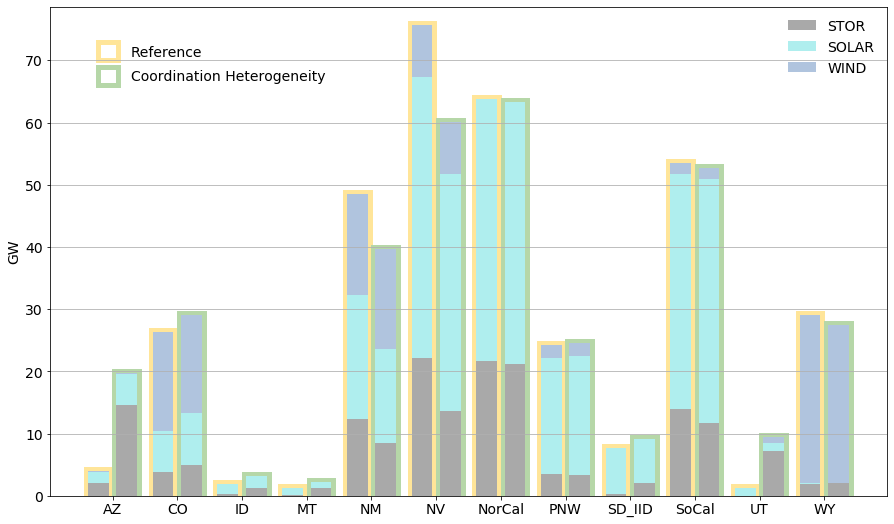

In [14]:
ind = np.arange(len(aggregated_cap[0].index))
bar_width = 0.32
bar_space = 0.44
linew = 9

fig, ax = plt.subplots(1, 1, figsize = (fig1, fig2))

ax.bar(ind, aggregated_cap[0].STOR + aggregated_cap[0].SOLAR + aggregated_cap[0].WIND, width = bar_width, 
       label = '', color = 'white', edgecolor = '#ffe599', linewidth = linew) 

ax.bar(ind, aggregated_cap[0].STOR, width = bar_width, label = 'STOR', color = 'darkgray')
ax.bar(ind, aggregated_cap[0].SOLAR, width = bar_width, label = 'SOLAR', color = 'paleturquoise', 
       bottom = aggregated_cap[0].STOR)
ax.bar(ind, aggregated_cap[0].WIND, width = bar_width, label = 'WIND', color = 'lightsteelblue', 
       bottom = aggregated_cap[0].STOR + aggregated_cap[0].SOLAR)

ax.bar(ind + bar_space, aggregated_cap[1].STOR + aggregated_cap[1].SOLAR + aggregated_cap[1].WIND, 
       width = bar_width, color = 'white', edgecolor = '#b6d7a8', linewidth = linew)

ax.bar(ind + bar_space, aggregated_cap[1].STOR, width = bar_width, color = 'darkgray')
ax.bar(ind + bar_space, aggregated_cap[1].SOLAR, width = bar_width, color = 'paleturquoise', 
       bottom = aggregated_cap[1].STOR)
ax.bar(ind + bar_space, aggregated_cap[1].WIND, width = bar_width, color = 'lightsteelblue', 
       bottom = aggregated_cap[1].STOR + aggregated_cap[1].SOLAR)

ax.set_ylabel('GW', fontsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)
ax.yaxis.grid()
ax.set_xticks(ind + bar_space / 2)
ax.set_xticklabels(aggregated_cap[0].index)
ax.legend(fontsize = 14, frameon = False)
ax.set_ylim(0, max(max(aggregated_cap[0].STOR + aggregated_cap[0].SOLAR + aggregated_cap[0].WIND), 
                   max(aggregated_cap[1].STOR + aggregated_cap[1].SOLAR + aggregated_cap[1].WIND)) + 3)

ax.add_patch(Rectangle((0, 70), 0.3, 3, fc = 'none', ec = '#ffe599', lw = 5))
ax.add_patch(Rectangle((0, 66), 0.3, 3, fc = 'none', ec = '#b6d7a8', lw = 5))
ax.text(0.5, 70.7, 'Reference', fontsize = 14)
ax.text(0.5, 66.7, 'Coordination Heterogeneity', fontsize = 14)

os.path.join(os.path.abspath(""), 'Results')

plt.savefig('capacity.pdf', dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)

### Cost by state

In [15]:
for x, name in enumerate(scenario_name_eeo):
    
    generators['eFixCostGen'] = generators.Fixed_OM_Cost_per_MWyr * allcap[x].OptValues + generators.Inv_Cost_per_MWyr * allcap[x].OptValues
    generators['eFixCostStor'] = generators.Fixed_OM_Cost_per_MWhyr * stor_merged[x].OptValues + generators.Inv_Cost_per_MWhyr * stor_merged[x].OptValues
    
    temp_slice = generators[(generators.STOR == 1) | (generators.LHYDRO == 1)]['eFixCostGen']
    generators.loc[(generators.STOR == 1) | (generators.LHYDRO == 1), 'eFixCostGen'] = 0
    generators.loc[(generators.STOR == 1) | (generators.LHYDRO == 1), 'eFixCostStor'] += temp_slice
    
    generators['eVarCostGen'] = dispatch[x].mul(generators.Var_Cost, axis = 0).mul(sample_weight, axis = 1).sum(axis = 1)
    generators['eStartCostUC'] = start[x].mul(generators.Start_Cost * generators.Cap_Size, axis = 0).sum(axis = 1)
    
    nc_final = []
    for y in nse[x]:
        nc_final.append(y.drop(columns = ['Index']).mul([cost_nonserved, cost_voluntary], axis = 0).mul(sample_weight, axis = 1).sum(axis = 1).sum())
        
    nsecost_final = pd.DataFrame()
    nsecost_final['Zone'] = generators.Zone.unique()
    nsecost_final['eNSECosts'] = nc_final
    nsecost_final = nsecost_final.set_index('Zone')
    
    invcost_existing = ((capline[x][0:len(network)]['OptValues'] - network.Line_Max_Flow_MW) * network.Line_Reinforcement_Cost_per_MWyr).tolist()
    invcost_proposed = [a * b for a, b in zip(capline[x][len(network):]['OptValues'].tolist(), pronetwork.Line_Reinforcement_Cost_per_MWyr.tolist())]
    invcost_fixed = [a * b for a, b in zip((network.Line_Reinforcement_Cost_per_MWyr / rein_to_fixed).tolist() + (pronetwork.Line_Reinforcement_Cost_per_MWyr / rein_to_fixed).tolist(), 
                            capline[x]['OptValues'].tolist())]
    
    invcost = pd.DataFrame()
    invcost['InvCost'] = invcost_existing + invcost_proposed
    invcost['FixedCost'] = invcost_fixed
    invcost = invcost.set_index(capline[x]['Path'])
    for colline in linenum: invcost[colline] = linenum[colline]
    state_line_cost = []
    for colline in linenum:
        state_line_cost.append(invcost[invcost[colline].isin([-1,1])][['InvCost', 'FixedCost']].sum().sum() / 2)
    
    state_line_cost_final = pd.DataFrame()
    state_line_cost_final['Zone'] = generators.Zone.unique()
    state_line_cost_final['eFixCostLine'] = state_line_cost
    state_line_cost_final = state_line_cost_final.set_index('Zone')
    
    if name == 'Coordination Heterogeneity':
        
        hurdle_cost = []
        for colline in linenum:

            zone_name = regiondf[regiondf.Code == colline]['Region'].tolist()[0]
            summ = 0
            for origin in [1, -1]:

                subdf = flow[flow[colline].isin([origin])].drop(columns = regiondf.Code.tolist())
                
                if origin == 1:
                    sumdf = subdf[subdf < 0].sum(1)
                else:
                    sumdf = subdf[subdf > 0].sum(1)

                for (path, total_flow)  in zip(sumdf.index, sumdf):
                    
                    if origin == 1:
                        if (path.split('_')[0] != 'SD') & (path.split('_')[2] != 'SD'):
                            end = path.split('_')[2]

                        if path.split('_')[0] == 'SD':
                            end = path.split('_')[3]
                        elif path.split('_')[2] == 'SD':
                            end = str(path.split('_')[2] + '_' + path.split('_')[3])

                    else:
                        if (path.split('_')[0] != 'SD') & (path.split('_')[2] != 'SD'):
                            end = path.split('_')[0]

                        if path.split('_')[0] == 'SD':
                            end = str(path.split('_')[0] + '_' + path.split('_')[1])
                        elif path.split('_')[2] == 'SD':
                            end = path.split('_')[0]
                    
                    if (zone_name == 'NorCal' or zone_name == 'SD_IID' or zone_name == 'SoCal') and (end == 'NorCal' or end == 'SD_IID' or end == 'SoCal'):
                        continue
                    else:
                        if origin == 1:
                            summ = summ + abs(total_flow * hurdle[hurdle.Regions == end]['Rate_From'].tolist()[0])
                        else:
                            summ = summ + total_flow * hurdle[hurdle.Regions == end]['Rate_From'].tolist()[0]

            hurdle_cost.append(summ)

        hurdle_cost_final = pd.DataFrame()
        hurdle_cost_final['Zone'] = generators.Zone.unique()
        hurdle_cost_final['eTransactionCost'] = hurdle_cost
        hurdle_cost_final = hurdle_cost_final.set_index('Zone')
    
    costsum = generators.groupby(['region','Zone'])[['eFixCostGen', 'eFixCostStor', 'eVarCostGen', 'eStartCostUC']].sum()
    costsum = costsum.reset_index(level = 'region')
    costsum = pd.merge(costsum, nsecost_final, how = 'outer', on = 'Zone')
    costsum = pd.merge(costsum, state_line_cost_final, how = 'outer', on = 'Zone')
    if name == 'Coordination Heterogeneity':
        costsum = pd.merge(costsum, hurdle_cost_final, how = 'outer', on = 'Zone')
    costsum = costsum.set_index('region')
    costsum.loc['CA'] = costsum.loc[['NorCal', 'SD_IID', 'SoCal']].sum()
    costsum = costsum.drop(['NorCal', 'SD_IID', 'SoCal'])
    
    if name == 'Coordination Heterogeneity':
        costsum_withins = pd.DataFrame(costsum.sum(axis = 1), columns = [name])
    else:
        costsum_withoutins = pd.DataFrame(costsum.sum(axis = 1), columns = [name])
        
    generators = generators.drop(['eFixCostGen', 'eFixCostStor', 'eVarCostGen', 'eStartCostUC'], axis=1)
    
cost_final = pd.merge(costsum_withoutins, costsum_withins, how = 'outer', on = 'region')
cost_final = cost_final * 10000 / 1000000000
cost_final.sort_index(inplace = True)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


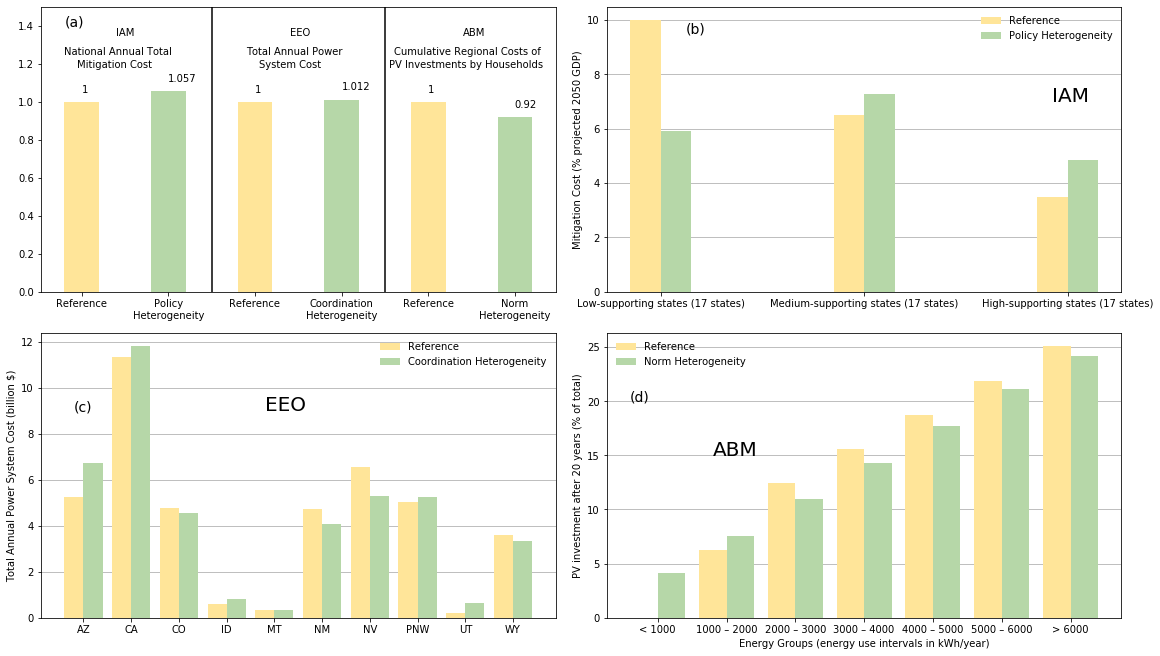

In [16]:
fig, ax = plt.subplots(2, 2, figsize = (16, 9), constrained_layout = True)

ax[0,0].bar([0,1,2,3,4,5], [iam_cost_withoutins, iam_cost_withins, 
                          1, sum(costs[1].Values) / sum(costs[0].Values),
                          abm_pv_withoutins, abm_pv_withins], width = 0.4, 
                  color = ['#ffe599', '#b6d7a8', '#ffe599', '#b6d7a8', '#ffe599', '#b6d7a8'])

ax[0,0].set_ylim(0, 1.5)
ax[0,0].tick_params(axis = 'y', labelsize = fs)
ax[0,0].tick_params(axis = 'x', labelsize = fs)

ax[0,0].text(0, iam_cost_withoutins + 0.05, round(iam_cost_withoutins, 3), fontsize = fs)
ax[0,0].text(1, iam_cost_withins + 0.05, round(iam_cost_withins, 3), fontsize = fs)
ax[0,0].text(0.4, 1.35, 'IAM', fontsize = fs)
ax[0,0].text(-0.2, 1.25, 'National Annual Total', fontsize = fs)
ax[0,0].text(-0.05, 1.18, 'Mitigation Cost', fontsize = fs)

ax[0,0].text(2, 1 + 0.05, round(1, 3), fontsize = fs)
ax[0,0].text(3, sum(costs[1].Values) / sum(costs[0].Values) + 0.05, 
        round(sum(costs[1].Values) / sum(costs[0].Values), 3), fontsize = fs)
ax[0,0].text(2.4, 1.35, 'EEO', fontsize = fs)
ax[0,0].text(1.9, 1.25, 'Total Annual Power', fontsize = fs)
ax[0,0].text(2.05, 1.18, 'System Cost', fontsize = fs)

ax[0,0].text(4, abm_pv_withoutins + 0.05, round(abm_pv_withoutins, 3), fontsize = fs)
ax[0,0].text(5, abm_pv_withins + 0.05, round(abm_pv_withins, 3), fontsize = fs)
ax[0,0].text(4.4, 1.35, 'ABM', fontsize = fs)
ax[0,0].text(3.6, 1.25, 'Cumulative Regional Costs of', fontsize = fs)
ax[0,0].text(3.55, 1.18, 'PV Investments by Households', fontsize = fs)
ax[0,0].text(-0.2, 1.4, '(a)', fontsize = 14)

ax[0,0].axvline(x = 1.5, color = 'black')
ax[0,0].axvline(x = 3.5, color = 'black')

ax[0,0].set_xticklabels(['', scenario_name_iam[0], scenario_name_iam[1].split(' ')[0] + "\n" + scenario_name_iam[1].split(' ')[1], 
                       scenario_name_eeo[0], scenario_name_eeo[1].split(' ')[0] + "\n" + scenario_name_eeo[1].split(' ')[1],
                       scenario_name_abm[0], scenario_name_abm[1].split(' ')[0] + "\n" + scenario_name_abm[1].split(' ')[1]])

for x in range(0,3):
    if x == 0:
        ax[x,1].bar(np.arange(len(iam_dist_costs.index)), iam_dist_costs['Without Institution'], 
                  width = 0.15, label = 'Reference', color = '#ffe599', zorder = 3)
        ax[x,1].bar(np.arange(len(iam_dist_costs.index)) + 0.15, iam_dist_costs['With institution'], width = 0.15, 
                  label = 'Policy Heterogeneity', color = '#b6d7a8', zorder = 3)
        ax[x,1].set_ylabel('Mitigation Cost (% projected 2050 GDP)', fontsize = fs)
        ax[x,1].set_xticks(np.arange(len(iam_dist_costs.index)) + 0.15 / 2)
        ax[x,1].set_xticklabels(iam_dist_costs.index)
        ax[x,1].tick_params(axis = 'x', labelsize = fs)
        ax[x,1].text(2, 7, 'IAM', fontsize = 20)
        ax[x,1].text(0.2, 9.5, '(b)', fontsize = 14)
    elif x == 1:
        ax[x,0].bar(np.arange(len(cost_final.index)), cost_final['Reference'], 
                  width = 0.4, label = 'Reference', color = '#ffe599', zorder = 3)
        ax[x,0].bar(np.arange(len(cost_final.index)) + 0.4, cost_final['Coordination Heterogeneity'], 
                  width = 0.4, label = 'Coordination Heterogeneity', color = '#b6d7a8', zorder = 3)
        ax[x,0].set_ylabel('Total Annual Power System Cost (billion $)', fontsize = fs)
        ax[x,0].set_xticks(np.arange(len(cost_final.index)) + 0.4 / 2)
        ax[x,0].set_xticklabels(cost_final.index)
        ax[x,0].tick_params(axis = 'x', labelsize = fs)
        ax[x,0].text(4, 9, 'EEO', fontsize = 20)
        ax[x,0].text(0, 9, '(c)', fontsize = 14)
    else:
        ax[x-1,1].bar(np.arange(len(abm_dist_costs.index)), abm_dist_costs['Without institutions(Rational agents)'], 
                  width = 0.4, label = 'Reference', color = '#ffe599', zorder = 3)
        ax[x-1,1].bar(np.arange(len(abm_dist_costs.index)) + 0.4, abm_dist_costs['With institutions(Behavioral agents)'], 
                  width = 0.4, label = 'Norm Heterogeneity', color = '#b6d7a8', zorder = 3)
        ax[x-1,1].set_ylabel('PV investment after 20 years (% of total)', fontsize = fs)
        ax[x-1,1].set_xlabel('Energy Groups (energy use intervals in kWh/year)', fontsize = fs)
        ax[x-1,1].set_xticks(np.arange(len(abm_dist_costs.index)) + 0.4 / 2)
        ax[x-1,1].set_xticklabels(abm_dist_costs.index)
        ax[x-1,1].tick_params(axis = 'x', labelsize = fs)
        ax[x-1,1].text(1, 15, 'ABM', fontsize = 20)
        ax[x-1,1].text(-0.2, 20, '(d)', fontsize = 14)
        
    ax[0,1].tick_params(axis = 'y', labelsize = fs)    
    ax[0,1].yaxis.grid(zorder = 0)
    ax[0,1].legend(fontsize = fs, frameon = False)
    
    ax[1,0].tick_params(axis = 'y', labelsize = fs)    
    ax[1,0].yaxis.grid(zorder = 0)
    ax[1,0].legend(fontsize = fs, frameon = False)
    
    ax[1,1].tick_params(axis = 'y', labelsize = fs)    
    ax[1,1].yaxis.grid(zorder = 0)
    ax[1,1].legend(fontsize = fs, frameon = False)

plt.savefig('combined_figure.pdf', dpi = dpi_qual, bbox_inches = 'tight', pad_inches = 0)